In [1]:
from torch import optim
import sys

# Function handle that returns an optimizer
def get_optimizer(model, name='adam', lr=0.001, momentum=0.9):
    if name == 'adam':
        return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif name == 'sgd':
        return optim.SGD(model.parameters(), lr=lr,momentum=momentum)
    else:
        print(f'[-] Unknown optimizer {name}')
        sys.exit(-1)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def get_lrs(optimizer, name='ReduceLROnPlateau'):
    if name == "ReduceLROnPlateau":
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

    elif name == "StepLR":
        return optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    elif name == 'MultiStepLR':
        return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,30], gamma=0.1)

    else:
        print(f"[-] Unknown scheduler {name}")
        sys.exit(-1)

In [2]:
import os
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, resnet
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights, mobilenetv3

# Global Variables
local = True
data_path = 'datasets/deeplearningproject/'
if not local:
    data_path = os.path.join('/', data_path)
images_path = os.path.join(data_path, 'train-jpg')
label_path = os.path.join(data_path, 'train_classes.csv')


network_weights = MobileNet_V3_Small_Weights.DEFAULT
encoder = mobilenet_v3_small(weights=network_weights)
# network_weights = ResNet50_Weights.DEFAULT
# encoder = resnet50(weights=network_weights)
preprocess = network_weights.transforms()


loss_function = nn.BCELoss()
optimizer_name = 'adam'
lrs_name = 'StepLR'


batch_size = 40
epochs = 20
workers = 0


In [3]:
def reset_parameters(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1) # Why 1?
            torch.nn.init.constant_(m.bias, 0) # Why 0?
        elif isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)

#reset_parameters(model)

In [4]:
import torch.nn.functional as F


def Net():
    for param in encoder.parameters():
        param.requires_grad = False


    decoder = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(in_features=576,out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=17),
        nn.Sigmoid()
    )
    for param in decoder.parameters():
        param.requires_grad=True

    if isinstance(encoder, mobilenetv3.MobileNetV3):
        encoder.classifier = decoder
    elif isinstance(encoder, resnet.ResNet):
        encoder.fc = decoder
    else:
        print(f"[-] Unknown encoder Model: {type(encoder)}")

    return encoder

model = Net()

# print('Network parameters:\n')
# print(model)

# Print parameter shapes
# for name, param in model.named_parameters(): print('parameter',name,param.shape)

In [5]:
#weights = ResNet50_Weights.DEFAULT
#preprocess = weights.transforms()
#
#img = images[0]
#print(img.shape)
#img_transformed = preprocess(img)
#print(img_transformed.shape)
#
#scores = model(images)
#print(scores.shape)

In [6]:
def accuracy(scores, yb):
    # print("scores", scores.dtype)
    # print("yb", yb.dtype)
    # Binarize predictions via thresholding
    scores[scores>=0.5] = 1

    return (scores == yb).float().mean()

#print('Accuracy', accuracy(scores,labels))

# loss_func = F.cross_entropy

#loss = loss_func(scores, labels)
#print('Loss', loss)

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
from time import process_time
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms


class MultilabelDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None, preprocessor=None):
        self.img_dataframe = dataframe  # pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.preprocessor = preprocessor

        # Encode labels
        tags = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
         'selective_logging', 'blow_down']
        split_tags = [row.split(" ") for row in self.img_dataframe["tags"]]
        mlb = MultiLabelBinarizer(classes=tags)
        mlb.fit(split_tags)
        self.img_labels = mlb.transform(split_tags).astype('float32')  # BCELoss does not accept integers *for some reason*

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # print(idx)
        # print(self.img_dataframe[idx-10:idx+10])
        img_path = os.path.join(self.img_dir, self.img_dataframe.iloc[idx, 0] + '.jpg')
        # print(img_path)
        pre_time = process_time()
        image = read_image(img_path)
        image = image [:3,:,:] #remove alpha channel
        loaded_time = process_time()

        if self.preprocessor != None:
            image = image/255 #required for preprocessor | normalize each picture
            image = self.preprocessor(image)
        else:
            image = 2 * (image/255 - 0.5) #normalize each picture

        processed_time = process_time()
        labels = self.img_labels[idx]

        transform_time = process_time()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)

        post_time = process_time()

        # print("load", loaded_time - pre_time, "processing", processed_time - loaded_time, "labels", transform_time - processed_time, "transform", post_time - transform_time)
        # print("total", post_time - pre_time)
        return image, labels

In [8]:
from sklearn.model_selection import train_test_split


labels = pd.read_csv(label_path)
train_data, test_daa = train_test_split(labels[:500], train_size=0.9)

trainset = MultilabelDataset(
    train_data,
    images_path,
    preprocessor=preprocess
)

testset = MultilabelDataset(
    test_daa,
    images_path,
    preprocessor=preprocess
)

In [9]:
from torch import optim
import matplotlib.pyplot as plt

# Function to fit a model
def fit(model,
        opt,
        lr_scheduler,
        loss_func,
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True,
        workers=0):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=workers, persistent_workers=workers)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=workers, persistent_workers=workers)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=workers, persistent_workers=workers)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=workers, persistent_workers=workers)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs
  
  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)
  
  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    if torch.cuda.is_available():
        valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss_history.append(valid_loss.detach().cpu().numpy())
        plot_time_valid.append(t)
    else:
        valid_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss_history.append(valid_loss.detach().cpu().numpy())
        plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode    

    for xb, yb in train_dl:

      # Forward prop      
      if torch.cuda.is_available():
        pred = model(xb.cuda())
        loss = loss_func(pred, yb.cuda())
      else:
        pred = model(xb)
        loss = loss_func(pred, yb) 

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()
      
      # Update model parameters
      opt.step()
      opt.zero_grad()


      # Validation loss and accuracy
      if t % 10 == 0:
        model.eval() # Test mode
        with torch.no_grad():
            if torch.cuda.is_available():
                valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
                valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            else:
                valid_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
                valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
        
            valid_loss_history.append(valid_loss.detach().cpu().numpy())
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        
        model.train() # Back to train mode
    
    # Update learning rate once per epoch 
    lr_scheduler.step()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    l, = plt.plot(plot_time_valid,valid_loss_history)
    lines.append(l)
    labels.append('Validation')  
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history

Epochs: 20 Batches per epoch: 12 Total number of batches 240


/home/gro/Documents/Uni/Erasmus/Vorlesungen/DLVR/Project/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


t 10 lr 0.001 train loss 0.3454329 val loss 0.676524 val accuracy 0.07132353
t 20 lr 0.001 train loss 0.2921222 val loss 0.6241986 val accuracy 0.08382353
t 30 lr 0.001 train loss 0.25867376 val loss 0.59141666 val accuracy 0.07058824
t 40 lr 0.001 train loss 0.22250277 val loss 0.55884236 val accuracy 0.058823533
t 50 lr 0.001 train loss 0.20706007 val loss 0.51673824 val accuracy 0.06985294
t 60 lr 0.001 train loss 0.21047467 val loss 0.46211383 val accuracy 0.08014706
t 70 lr 0.001 train loss 0.17983048 val loss 0.41305315 val accuracy 0.089705884
t 80 lr 0.001 train loss 0.19266748 val loss 0.37223274 val accuracy 0.09411765
t 90 lr 0.001 train loss 0.20983447 val loss 0.33766103 val accuracy 0.09852941
t 100 lr 0.001 train loss 0.17375748 val loss 0.31172672 val accuracy 0.09852941
t 110 lr 0.001 train loss 0.14695583 val loss 0.29514962 val accuracy 0.09852941
t 120 lr 0.001 train loss 0.17624183 val loss 0.2797658 val accuracy 0.10147059
t 130 lr 0.0001 train loss 0.13790439 val

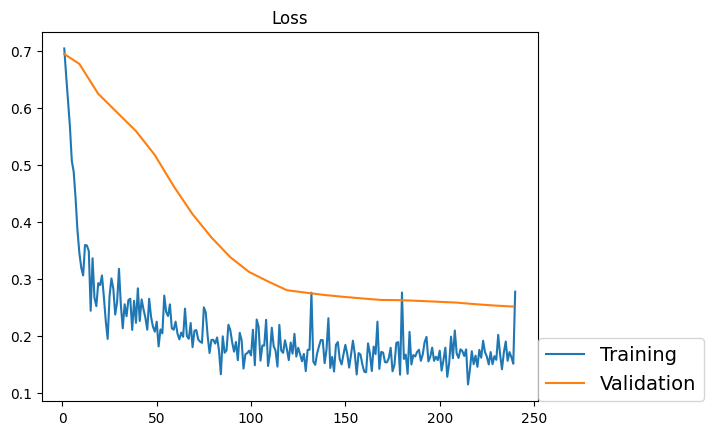

In [10]:
 # Re-initialize weights
#reset_parameters(model)
model = Net()

optimizer = get_optimizer(model, optimizer_name)
lrs = get_lrs(optimizer, lrs_name)

# Train with defaul settings.
train_loss_history = fit(model, loss_func=loss_function,\
                         opt=optimizer, lr_scheduler=lrs, bs=batch_size, epochs=epochs, workers=workers)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=523d2edd-b418-4a9e-989b-f9b1860f5009' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>